## Loading intial packages 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
%matplotlib inline

## Loading test images

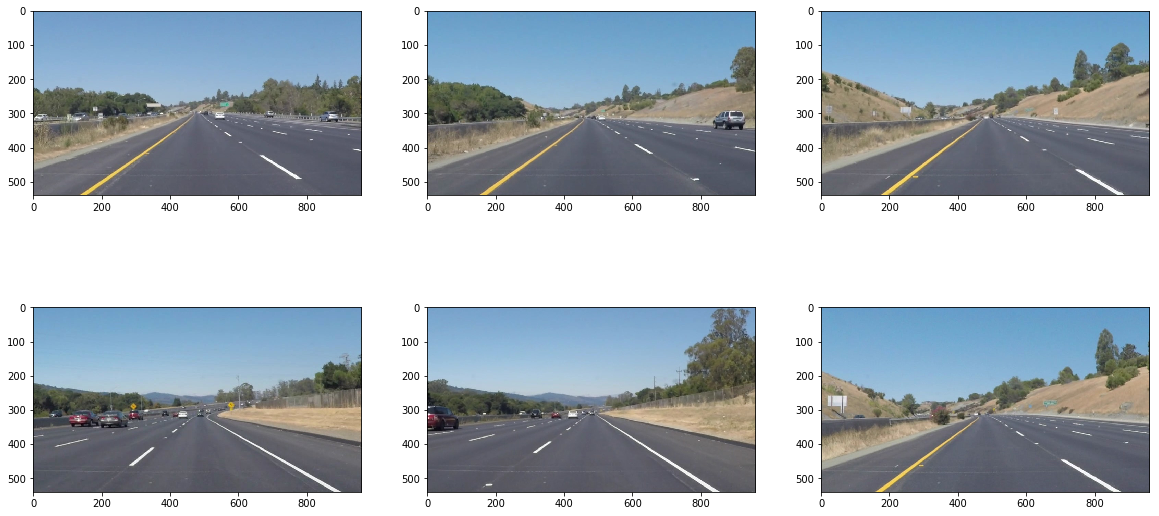

In [2]:
#reading in images
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
col = 3
row = len(test_images) / col

plt.figure(figsize=(20,10))
for i, image in enumerate(test_images):
    plt.subplot(row,col,i+1)
    plt.imshow(image)
plt.show()
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Candy Edge Detection

In the project, Candy edge Detection is used for finding lane lines. There are several steps for achieving the purpose:
    1. Gray Scaling
    2. Gaussian Blur
    3. Edge Detection

###     1. Gray Scaling

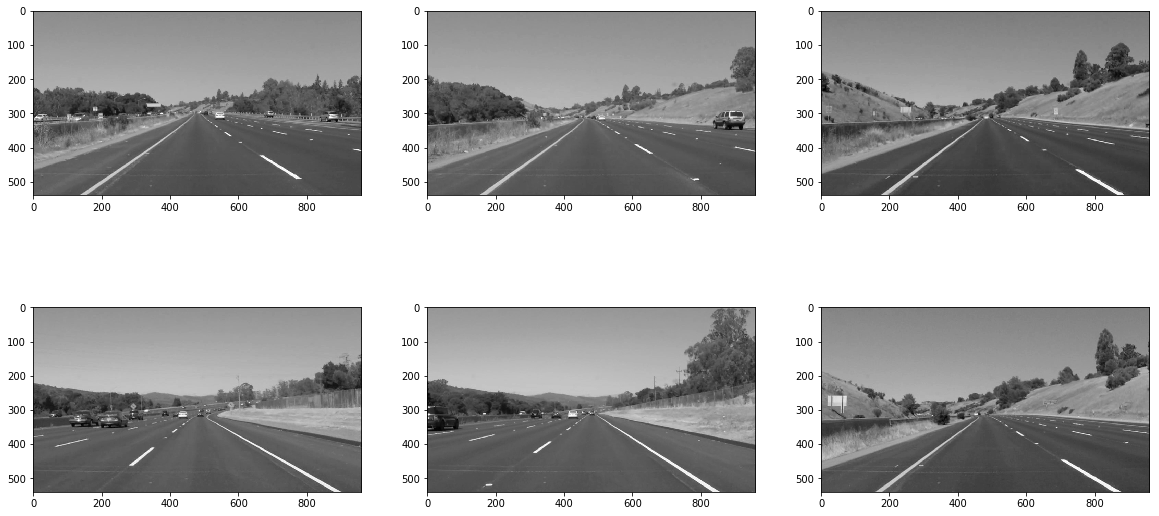

In [3]:
def grayscale(img):

    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray_images = []
plt.figure(figsize=(20,10))
for i, image in enumerate(test_images):
    gray_image = grayscale(image)
    plt.subplot(row,col,i+1)
    plt.imshow(gray_image,cmap='gray')
    gray_images.append(gray_image)
plt.show()

### 2. Gaussian Blur

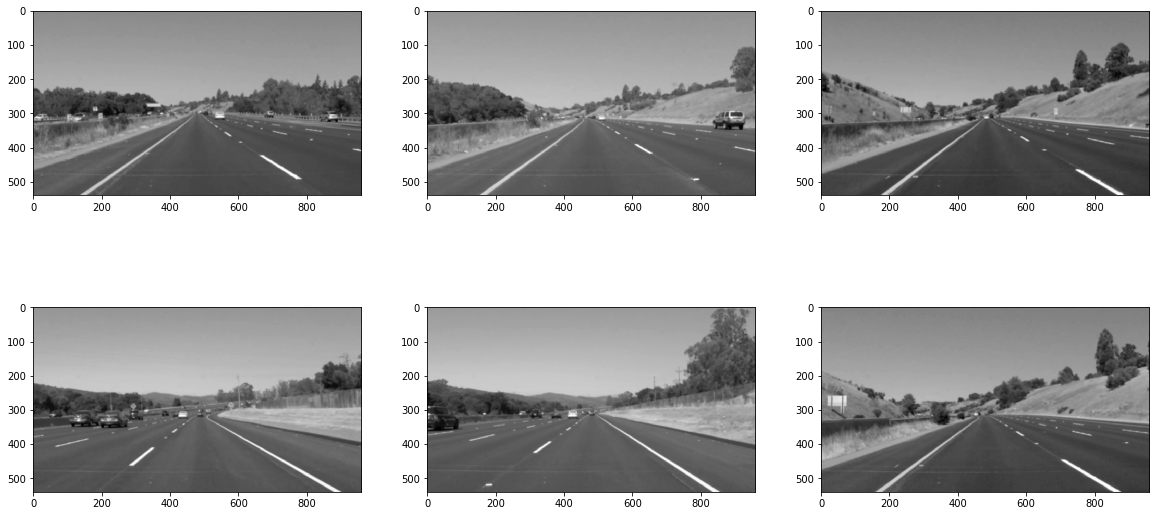

In [4]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

blur_grays = []
kernel_size = 7
plt.figure(figsize=(20,10))
for i, image in enumerate(gray_images):
    blur_gray = gaussian_blur(image,kernel_size)
    plt.subplot(row,col,i+1)
    plt.imshow(blur_gray,cmap='gray')
    blur_grays.append(blur_gray)
plt.show()

### 3. Edge Detection

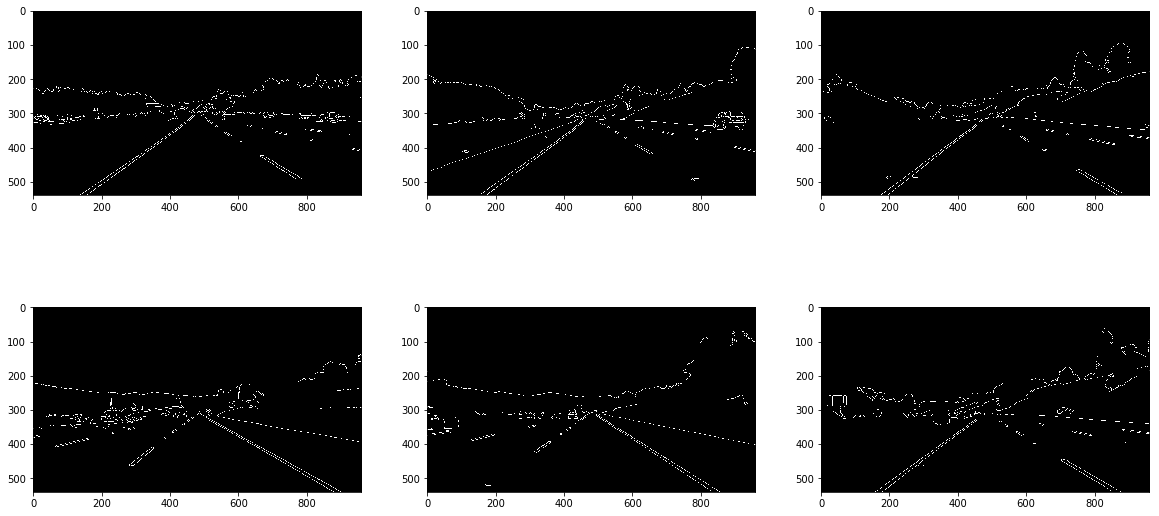

In [5]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)



low_threshold = 50
high_threshold = 150
plt.figure(figsize=(20,10))
edges_images = []
for i, image in enumerate(blur_grays):
    edges = canny(image, low_threshold, high_threshold)
    plt.subplot(row,col,i+1)
    plt.imshow(edges,cmap='gray')
    edges_images.append(edges)
plt.show()

## Region of interest

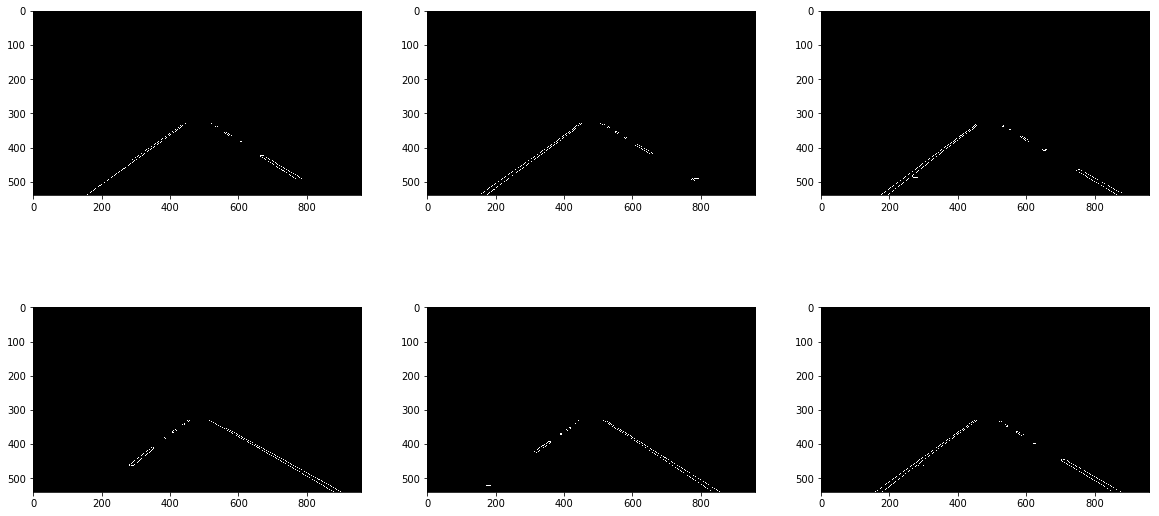

In [6]:
def region_of_interest(img, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


imshape = image.shape
vertices = np.array([[(imshape[1]*0.15,imshape[0]),(440, 330), (520, 330), (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
masked_edges_images = []

plt.figure(figsize=(20,10))
for i, image in enumerate(edges_images):
    masked_edges = region_of_interest(image, vertices)
    plt.subplot(row,col,i+1)
    plt.imshow(masked_edges,cmap='gray')
    masked_edges_images.append(masked_edges)
plt.show()

## Hough Transform on Lane Detection

In [7]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
  
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines


In [8]:
def average_lines(lines):
    
    left_slope_intercept = []  # (slope, intercept)
    left_weight = [] 
    
    right_slope_intercept = []
    right_weight = []
    
    #average
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            intercept = y2 - slope * x2
            length = np.sqrt((y2-y1)**2 + (x2-x1)**2)
            if slope > 0:
                left_slope_intercept.append([slope,intercept])
                left_weight.append(length)
            else:
                #print (lines)
                #print (slope)
                right_slope_intercept.append([slope,intercept])
                right_weight.append(length)
                
    #print(left_slope_intercept)
    #print(left_weight)
    
    left_lane = np.dot(left_weight,left_slope_intercept)/np.sum(left_weight) if len(left_weight)>0 else None
    right_lane = np.dot(right_weight, right_slope_intercept)/np.sum(right_weight) if len(right_weight)>0 else None
    #print (np.sum(right_weight))
    #print (right_slope_intercept)
    
    return left_lane,right_lane


def extrapolate_lines(height, lane):
    
    if lane is None: return None
    
    #print(lane)
    
    y1 = int(height)
    y2 = int(height * 0.6)
    x1 = int((y1 - lane[1])/lane[0])
    x2 = int((y2 - lane[1])/lane[0])
    
    
    
    return [x1,y1,x2,y2]

In [9]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=9):
    
    left_slope_intercept = []  # (slope, intercept)
    left_weight = [] 
    
    right_slope_intercept = []
    right_weight = []
    
    
    left_lane, right_lane = average_lines(lines)
    ex_left_lane = extrapolate_lines(image.shape[0],left_lane)
    ex_right_lane = extrapolate_lines(image.shape[0],right_lane)
    
    if ex_left_lane is not None:
        x1,y1,x2,y2 = ex_left_lane
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
     
    if ex_right_lane is not None:
        x1,y1,x2,y2 = ex_right_lane
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [10]:
def image_pipeline(image):
    
    gray = grayscale (image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    #print (edges)

    # Define a region we are interested in
    imshape = image.shape
    vertices = np.array([[(imshape[1]*0.15,imshape[0]),(440, 330), (520, 330), (imshape[1]*0.95,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    test_edges = region_of_interest(image, vertices)
    #plt.imshow (test_edges)
    #plt.imshow(masked_edges,cmap='gray')


    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 20
    min_line_len = 20
    max_line_gap = 300

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)


    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    # Draw the lines on the edge image

    #lines_edges = weighted_img(color_edges, line_image) 
    lane_image = weighted_img(line_image, image)
    
    return lane_image




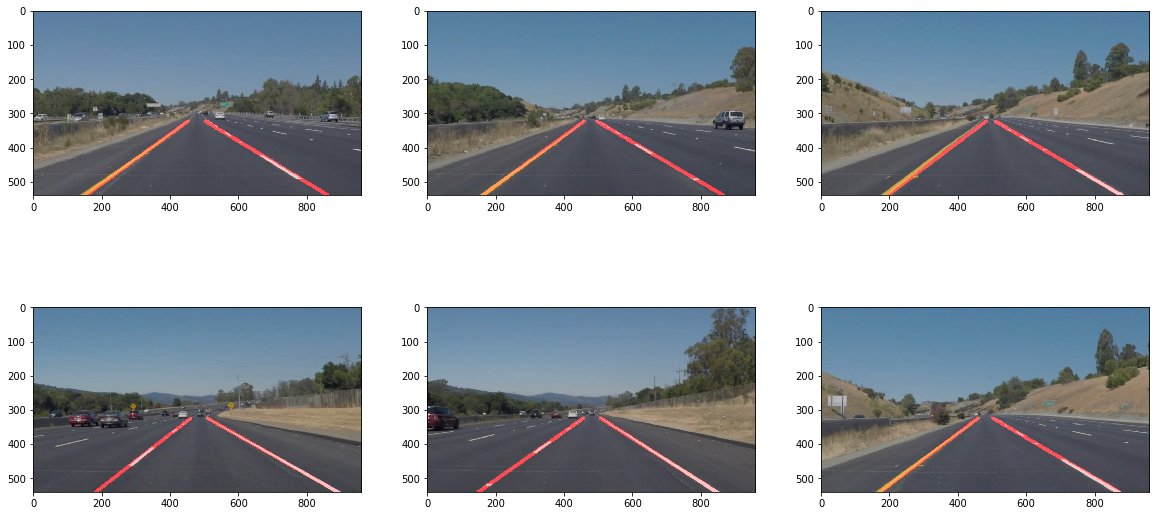

In [11]:
lanes_images = []

plt.figure(figsize=(20,10))
for i, image in enumerate(test_images):
    lanes_image = image_pipeline(image)
    plt.subplot(row,col,i+1)
    plt.imshow(lanes_image)
    lanes_images.append(lanes_image)
plt.show()

# Test on video clips

## Import video packages

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")#.subclip(0,5)
white_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:10<00:00, 20.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 58.5 s, sys: 249 ms, total: 58.8 s
Wall time: 11.2 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(image_pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:31<00:00, 21.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 57s, sys: 571 ms, total: 2min 58s
Wall time: 31.8 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))